In [2]:
# !pip install transformers
# !pip install summarizer
# !pip install datasets
!pip install ipykernel

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import pandas as pd

import torch


In [4]:
# !wget -r -N -c -np --user cmgao --ask-password https://physionet.org/files/mimiciii/1.4/

In [5]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# cd 'drive/MyDrive/SPRING 2024/DSGA 1015/project'

In [6]:
# cd 'drive/MyDrive/SPRING 2024/DSGA 1015/project'


In [7]:
# from google.colab import files

notes = pd.read_csv('physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz', compression='gzip')

/var/folders/51/42w_kz156q920kx3w9jz1lwm0000gn/T/ipykernel_24456/4025246869.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv('physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz', compression='gzip')


In [8]:
# notes = pd.read_csv('physionet.org/files/mimiciii/1.4/NOTEEVENTS.csv.gz', compression='gzip')
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [9]:
notes['CATEGORY'].value_counts()

CATEGORY
Nursing/other        822497
Radiology            522279
Nursing              223556
ECG                  209051
Physician            141624
Discharge summary     59652
Echo                  45794
Respiratory           31739
Nutrition              9418
General                8301
Rehab Services         5431
Social Work            2670
Case Management         967
Pharmacy                103
Consult                  98
Name: count, dtype: int64

In [10]:
admissions = pd.read_csv('physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz', compression='gzip')
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [11]:
# len(admissions['SUBJECT_ID'].unique())

In [12]:
patients = pd.read_csv('physionet.org/files/mimiciii/1.4/PATIENTS.csv.gz', compression='gzip')
patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


### Analyze NOTEEVENTS

In [13]:
import nltk
import string
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import re
# from datasets import load_dataset, Dataset


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinegao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
discharge = notes[notes['CATEGORY']=='Discharge summary']

In [15]:
notes_grouped = pd.DataFrame(discharge.groupby(['SUBJECT_ID'])['TEXT'].apply(lambda x: ' '.join(x)))

In [16]:
def remove_markups(text_in):
    text_out = text_in.replace('\n', ' ')
    return text_out

def remove_stars(text_in):
    text_out = re.sub(r'\[\*\*[A-Za-z\s]*[Nn]ame[^\]|\[]*\*\*]', '<NAME>', text_in)
    text_out = re.sub(r'\[\*\*[0-9][^\]|\[]*\*\*]', '<DATE>', text_out)
    text_out = re.sub(r'\[\*\*[^\]|\[]*\*\*]', '<ENTITY>', text_out)
    return text_out

def to_lower(text_in):
    text_out = text_in.lower()
    return text_out

def clean_underscores(text_in):
    text_out = text_in.replace('_', '')
    return text_out


def clean_commas(text_in):
    text_out = text_in.replace(',', '')
    return text_out


def clear_spaces(text_in):
    text_out = re.sub(r' +', ' ', text_in)
    return text_out

def clean_text(text_in):
    if text_in is None:
        return None
    text_out = remove_markups(text_in)
    text_out = remove_stars(text_out)
    text_out = to_lower(text_out)
    text_out = clean_underscores(text_out)
    text_out = clean_commas(text_out)
    text_out = clear_spaces(text_out)
    return text_out

In [17]:
import re
pd.set_option('display.max_colwidth',1)


df = pd.DataFrame()

# present_illness_regex = re.compile(r'HISTORY OF PRESENT ILLNESS:(.*?)(PAST MEDICAL HISTORY|PHYSICAL EXAMINATION:|PHYSICAL EXAM:|Medications|LABORATORY DATA:|MEDICATION|PHYSICAL EXAM ON ADMISSION:|$)', re.DOTALL)
present_illness_regex = re.compile(r'HISTORY OF PRESENT ILLNESS:(.*?)(?=\n\n[A-Z])', re.DOTALL)
medical_history_regex = re.compile(r'PAST MEDICAL HISTORY:(.*?)(?=\n\n[A-Z])', re.DOTALL)
social_history_regex = re.compile(r'SOCIAL HISTORY:(.*?)(?=\n\n[A-Z])', re.DOTALL)
# family_history_regex = re.compile(r'FAMILY HISTORY:(.*?)(PHYSICAL EXAMINATION|social history:|PHYSICAL|EXAMINATION UPON ADMISSION:|SOCIAL HISTORY|$)', re.DOTALL)
family_history_regex = re.compile(r'FAMILY HISTORY:(.*?)(?=\n\n[A-Z])', re.DOTALL)
# physical_exam_regex = re.compile(r'PHYSICAL EXAMINATION:(.*?)(?=\n\n[A-Z])', re.DOTALL)

# social_history_regex = re.compile(r'SOCIAL HISTORY(.*)PHYSICAL EXAMINATION:', re.DOTALL)
# final_report_regex = re.compile(r'FINAL REPORT:(.*)', re.DOTALL)

# Extract text following the matched patterns
def extract_text(text, regex):
    match = regex.search(text)
    return match.group(1).strip() if match else None

# Apply extraction function to create new columns
df['present_illness'] = notes_grouped['TEXT'].apply(lambda x: extract_text(x, present_illness_regex))
df['medical_history'] = notes_grouped['TEXT'].apply(lambda x: extract_text(x, medical_history_regex))
df['family_history'] = notes_grouped['TEXT'].apply(lambda x: extract_text(x, family_history_regex))
df['social_history'] = notes_grouped['TEXT'].apply(lambda x: extract_text(x, social_history_regex))
# df['physical_exam'] = notes_grouped['TEXT'].apply(lambda x: extract_text(x, physical_exam_regex))

# df.head()

In [18]:
df['present_illness'] = df['present_illness'].apply(clean_text)
df['medical_history'] = df['medical_history'].apply(clean_text)
df['social_history'] = df['social_history'].apply(clean_text)
df['family_history'] = df['family_history'].apply(clean_text)

In [19]:
df.dropna(axis=0, how='all', inplace=True)
# df

In [20]:
len(df)

12690

## HISTORY OF PRESENT ILLNESS



In [97]:
import gensim
import gensim.corpora as corpora
from gensim.models import HdpModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint # Gensim

In [21]:
def preprocess(doc):
  '''function to preprocess documents
    remove punctuation
    tokenize words
    remove stop words
    remove unnecessary patterns
    return as list
  '''
  d = doc.translate(str.maketrans('', '', string.punctuation)).lower()
  tokens = word_tokenize(d)
  stop_words = set(stopwords.words("english"))
  nostop = [word for word in tokens if word not in stop_words]
  patterns = ['name', '>', '(', ')', '.', '``']
  no_pattern = [word for word in nostop if not any(re.findall('|'.join(patterns), word))]

  # output = [PorterStemmer().stem(word) for word in nostop]
  # output = ' '.join(nostop)
  return no_pattern

# vectorizer = CountVectorizer()

In [98]:
present_df = df[['present_illness']].dropna()
present_df['process'] = present_df['present_illness'].apply(preprocess)

In [99]:
text = list(present_df['process'].apply(' '.join))

count_vectorizer = CountVectorizer(lowercase=False)
dtm= count_vectorizer.fit_transform(text)
print('DTM shape:', dtm.shape)

vocab = count_vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=vocab)


DTM shape: (10107, 16626)


In [100]:
# present_df['list_text'] = list(present_df['process_text_list'])
dict = list(present_df['process'])

common_dictionary = Dictionary(dict)
corpus = [common_dictionary.doc2bow(text) for text in dict]
 
lda = LdaModel(corpus, id2word=common_dictionary, num_topics=7,
               alpha='symmetric', eta='symmetric',random_state=42,
               iterations=1000,passes=2)

terms_topic1 = lda.get_topic_terms(1)
# print('Top words (IDs) for topic 1:', terms_topic1)
print('Top word from topic 1:', common_dictionary[terms_topic1[0][0]])

pprint(lda.print_topics())

Top word from topic 1: patient
[(0,
  '0.039*"artery" + 0.036*"coronary" + 0.027*"left" + 0.026*"disease" + '
  '0.021*"patient" + 0.017*"catheterization" + 0.017*"entity" + 0.017*"date" + '
  '0.016*"cardiac" + 0.012*"history"'),
 (1,
  '0.029*"patient" + 0.025*"name" + 0.012*"history" + 0.012*"pain" + '
  '0.011*"left" + 0.011*"referred" + 0.011*"chest" + 0.011*"dr" + 0.011*"date" '
  '+ 0.010*"year"'),
 (2,
  '0.043*"date" + 0.018*"renal" + 0.015*"right" + 0.013*"left" + '
  '0.013*"patient" + 0.011*"cell" + 0.010*"underwent" + 0.009*"therapy" + '
  '0.009*"showed" + 0.009*"revealed"'),
 (3,
  '0.037*"patient" + 0.023*"left" + 0.022*"head" + 0.021*"right" + '
  '0.019*"loss" + 0.018*"entity" + 0.015*"ct" + 0.014*"consciousness" + '
  '0.014*"found" + 0.010*"hospital"'),
 (4,
  '0.035*"patient" + 0.018*"entity" + 0.016*"pain" + 0.011*"date" + '
  '0.010*"history" + 0.009*"emergency" + 0.009*"chest" + 0.009*"admission" + '
  '0.008*"hospital" + 0.007*"prior"'),
 (5,
  '0.028*"patient"

In [102]:
print('\nPerplexity: ', lda.log_perplexity(corpus))


Perplexity:  -7.210974970967825


In [103]:
from itertools import product

alphas = ['symmetric', 'asymmetric']
etas = ['symmetric', 'auto']
num_topics = [3, 4, 5, 6, 7, 10]

# Generate all combinations of parameters
param_grid = product(alphas, etas, num_topics)

best_model = None
best_perplexity = float('inf')  # Initialize with infinity

# Manually perform grid search
for params in param_grid:
    alpha, eta, num_topics = params
    lda_model = LdaModel(corpus=corpus, id2word=common_dictionary, alpha=alpha, eta=eta, num_topics=num_topics)
    perplexity = lda_model.log_perplexity(corpus)
    print("Parameters:", params)
    print("Perplexity Score:", perplexity)
    print()
    if perplexity < best_perplexity:
        best_model = lda_model
        best_perplexity = perplexity

# Print the best model and its perplexity score
print("Best Model:", best_model)
print("Best Perplexity Score:", best_perplexity)

Parameters: ('symmetric', 'symmetric', 3)
Perplexity Score: -7.190247974448966

Parameters: ('symmetric', 'symmetric', 4)
Perplexity Score: -7.153016102612567

Parameters: ('symmetric', 'symmetric', 5)
Perplexity Score: -7.154299822613094

Parameters: ('symmetric', 'symmetric', 6)
Perplexity Score: -7.155879551634312

Parameters: ('symmetric', 'symmetric', 7)
Perplexity Score: -7.233970832494388

Parameters: ('symmetric', 'symmetric', 10)
Perplexity Score: -7.357706259893269

Parameters: ('symmetric', 'auto', 3)
Perplexity Score: -7.250209044679282

Parameters: ('symmetric', 'auto', 4)
Perplexity Score: -7.147370477040548

Parameters: ('symmetric', 'auto', 5)
Perplexity Score: -7.1815588329692215

Parameters: ('symmetric', 'auto', 6)
Perplexity Score: -7.17975455158062

Parameters: ('symmetric', 'auto', 7)
Perplexity Score: -7.185972993106388

Parameters: ('symmetric', 'auto', 10)
Perplexity Score: -7.315490711477498

Parameters: ('asymmetric', 'symmetric', 3)
Perplexity Score: -7.1907

## PAST MEDICAL HISTORY

In [104]:
medical_df = df[['medical_history']].dropna()

medical_df['process'] = medical_df['medical_history'].apply(preprocess)

text = list(medical_df['process'].apply(' '.join))

count_vectorizer = CountVectorizer(lowercase=False)
dtm = count_vectorizer.fit_transform(text)
print('DTM shape:', dtm.shape)

vocab = count_vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=vocab)

dict = list(medical_df['process'])

common_dictionary = Dictionary(dict)
corpus = [common_dictionary.doc2bow(text) for text in dict]

lda = LdaModel(corpus, id2word=common_dictionary, num_topics=7,
               alpha='symmetric', eta='symmetric',random_state=42,
               iterations=1000,passes=2)

terms_topic1 = lda.get_topic_terms(1)
print('Top words (IDs) for topic 1:', terms_topic1)
print('Top word from topic 1:', common_dictionary[terms_topic1[0][0]])

pprint(lda.print_topics())

DTM shape: (9674, 10471)
Top words (IDs) for topic 1: [(36, 0.04198296), (57, 0.03862433), (29, 0.012513902), (61, 0.01196888), (8, 0.0116825225), (2220, 0.010665828), (0, 0.009712837), (59, 0.009498436), (10, 0.009466534), (175, 0.0094177835)]
Top word from topic 1: date
[(0,
  '0.066*"sp" + 0.050*"date" + 0.019*"cardiac" + 0.015*"none" + 0.012*"entity" '
  '+ 0.011*"htn" + 0.010*"stenosis" + 0.009*"cabg" + 0.009*"name" + '
  '0.008*"risk"'),
 (1,
  '0.042*"date" + 0.039*"history" + 0.013*"chronic" + 0.012*"left" + 0.012*"2" '
  '+ 0.011*"ho" + 0.010*"1" + 0.009*"hypertension" + 0.009*"3" + 0.009*"sp"'),
 (2,
  '0.045*"disease" + 0.030*"artery" + 0.029*"post" + 0.029*"status" + '
  '0.029*"2" + 0.027*"coronary" + 0.025*"1" + 0.024*"date" + 0.024*"3" + '
  '0.022*"hypertension"'),
 (3,
  '0.064*"history" + 0.029*"past" + 0.021*"medical" + 0.018*"patient" + '
  '0.016*"1" + 0.016*"abuse" + 0.016*"hepatitis" + 0.016*"2" + '
  '0.013*"depression" + 0.013*"3"'),
 (4,
  '0.049*"date" + 0.04

In [105]:
alphas = ['symmetric', 'asymmetric']
etas = ['symmetric', 'auto']
num_topics = [3, 4, 5, 6, 7, 10]

# Generate all combinations of parameters
param_grid = product(alphas, etas, num_topics)

best_model = None
best_perplexity = float('inf')  # Initialize with infinity

# Manually perform grid search
for params in param_grid:
    alpha, eta, num_topics = params
    lda_model = LdaModel(corpus=corpus, id2word=common_dictionary, alpha=alpha, eta=eta, num_topics=num_topics)
    perplexity = lda_model.log_perplexity(corpus)
    print("Parameters:", params)
    print("Perplexity Score:", perplexity)
    print()
    if perplexity < best_perplexity:
        best_model = lda_model
        best_perplexity = perplexity

# Print the best model and its perplexity score
print("Best Model:", best_model)
print("Best Perplexity Score:", best_perplexity)

Parameters: ('symmetric', 'symmetric', 3)
Perplexity Score: -6.609028871608517

Parameters: ('symmetric', 'symmetric', 4)
Perplexity Score: -6.614856999733051

Parameters: ('symmetric', 'symmetric', 5)
Perplexity Score: -6.671153192484495

Parameters: ('symmetric', 'symmetric', 6)
Perplexity Score: -6.684725485994536

Parameters: ('symmetric', 'symmetric', 7)
Perplexity Score: -6.696053676897214

Parameters: ('symmetric', 'symmetric', 10)
Perplexity Score: -6.922572478443135

Parameters: ('symmetric', 'auto', 3)
Perplexity Score: -6.593722668096515

Parameters: ('symmetric', 'auto', 4)
Perplexity Score: -6.633603468109191

Parameters: ('symmetric', 'auto', 5)
Perplexity Score: -6.63371435341231

Parameters: ('symmetric', 'auto', 6)
Perplexity Score: -6.65734625095417

Parameters: ('symmetric', 'auto', 7)
Perplexity Score: -6.675328791195145

Parameters: ('symmetric', 'auto', 10)
Perplexity Score: -6.876822421576005

Parameters: ('asymmetric', 'symmetric', 3)
Perplexity Score: -6.627802

Past medical history include hypertesnsion, coronary (heart) disease, hepatitis, abuse, depression, cancer, diabetes, hypercholestorelemia. 

## SOCIAL HISTORY

In [106]:
social_df = df[['social_history']].dropna()
social_df['process'] = social_df['social_history'].apply(preprocess)

text = list(social_df['process'].apply(' '.join))

count_vectorizer = CountVectorizer(lowercase=False)
dtm = count_vectorizer.fit_transform(text)
print('DTM shape:', dtm.shape)

vocab = count_vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=vocab)

dict = list(social_df['process'])

common_dictionary = Dictionary(dict)
corpus = [common_dictionary.doc2bow(text) for text in dict]
print(len(corpus))
lda = LdaModel(corpus, id2word=common_dictionary, num_topics=7,
               alpha='symmetric', eta='symmetric',random_state=42,
               iterations=1000,passes=2)

terms_topic1 = lda.get_topic_terms(1)
print('Top words (IDs) for topic 1:', terms_topic1)
print('Top word from topic 1:', common_dictionary[terms_topic1[0][0]])

pprint(lda.print_topics())

DTM shape: (5987, 4394)
5987
Top words (IDs) for topic 1: [(70, 0.068088606), (8, 0.06136148), (13, 0.03503567), (27, 0.030536914), (9, 0.027131947), (10, 0.02161427), (21, 0.016548775), (29, 0.012331584), (97, 0.011988659), (81, 0.010571618)]
Top word from topic 1: name
[(0,
  '0.031*"entity" + 0.030*"name" + 0.023*"married" + 0.020*"children" + '
  '0.017*"lives" + 0.016*"years" + 0.015*"patient" + 0.013*"ago" + 0.012*"one" '
  '+ 0.011*"parents"'),
 (1,
  '0.068*"name" + 0.061*"entity" + 0.035*"patient" + 0.031*"lives" + '
  '0.027*"history" + 0.022*"home" + 0.017*"alcohol" + 0.012*"tobacco" + '
  '0.012*"care" + 0.011*"daughter"'),
 (2,
  '0.055*"per" + 0.052*"day" + 0.043*"years" + 0.029*"patient" + 0.029*"one" + '
  '0.027*"lives" + 0.026*"two" + 0.024*"pack" + 0.023*"drinks" + '
  '0.022*"alcohol"'),
 (3,
  '0.067*"patient" + 0.044*"history" + 0.037*"alcohol" + 0.035*"lives" + '
  '0.028*"smoking" + 0.023*"entity" + 0.023*"use" + 0.020*"date" + '
  '0.019*"name" + 0.016*"pack"')

In [107]:
alphas = ['symmetric', 'asymmetric']
etas = ['symmetric', 'auto']
num_topics = [3, 4, 5, 6, 7, 10]

# Generate all combinations of parameters
param_grid = product(alphas, etas, num_topics)

best_model = None
best_perplexity = float('inf')  # Initialize with infinity

# Manually perform grid search
for params in param_grid:
    alpha, eta, num_topics = params
    lda_model = LdaModel(corpus=corpus, id2word=common_dictionary, alpha=alpha, eta=eta, num_topics=num_topics)
    perplexity = lda_model.log_perplexity(corpus)
    print("Parameters:", params)
    print("Perplexity Score:", perplexity)
    print()
    if perplexity < best_perplexity:
        best_model = lda_model
        best_perplexity = perplexity

# Print the best model and its perplexity score
print("Best Model:", best_model)
print("Best Perplexity Score:", best_perplexity)

Parameters: ('symmetric', 'symmetric', 3)
Perplexity Score: -5.824719719062003

Parameters: ('symmetric', 'symmetric', 4)
Perplexity Score: -5.868574236096425

Parameters: ('symmetric', 'symmetric', 5)
Perplexity Score: -5.896111039550339

Parameters: ('symmetric', 'symmetric', 6)
Perplexity Score: -5.898622177682806

Parameters: ('symmetric', 'symmetric', 7)
Perplexity Score: -5.950151619036397

Parameters: ('symmetric', 'symmetric', 10)
Perplexity Score: -6.14863659291316

Parameters: ('symmetric', 'auto', 3)
Perplexity Score: -5.757096617787107

Parameters: ('symmetric', 'auto', 4)
Perplexity Score: -5.836524166523515

Parameters: ('symmetric', 'auto', 5)
Perplexity Score: -5.840443308921176

Parameters: ('symmetric', 'auto', 6)
Perplexity Score: -5.864093865971947

Parameters: ('symmetric', 'auto', 7)
Perplexity Score: -5.9150732876474805

Parameters: ('symmetric', 'auto', 10)
Perplexity Score: -6.130002951503418

Parameters: ('asymmetric', 'symmetric', 3)
Perplexity Score: -5.7945

From social history, notable topics include history of smoking and alochol use. 

## FAMILY HISTORY

In [236]:
family_df = df[['family_history']].dropna()
family_df['process'] = family_df['family_history'].apply(preprocess)

text = list(family_df['process'].apply(' '.join))

count_vectorizer = CountVectorizer(lowercase=False)
dtm= count_vectorizer.fit_transform(text)
print('DTM shape:', dtm.shape)

vocab = count_vectorizer.get_feature_names_out()
dtm_df = pd.DataFrame(dtm.toarray(), columns=vocab)

dict = list(family_df['process'])

common_dictionary = Dictionary(dict)
corpus = [common_dictionary.doc2bow(text) for text in dict]

lda = LdaModel(corpus, id2word=common_dictionary, num_topics=7,
               alpha='symmetric', eta='symmetric',random_state=42,
               iterations=1000,passes=2)

terms_topic1 = lda.get_topic_terms(1)
print('Top words (IDs) for topic 1:', terms_topic1)
print('Top word from topic 1:', common_dictionary[terms_topic1[0][0]])

pprint(lda.print_topics())

DTM shape: (3270, 1911)
Top words (IDs) for topic 1: [(1, 0.11363703), (2, 0.11038901), (0, 0.08960538), (8, 0.08528997), (7, 0.06459548), (6, 0.062489215), (40, 0.032390144), (10, 0.024049914), (43, 0.013403826), (9, 0.012285543)]
Top word from topic 1: history
[(0,
  '0.063*"disease" + 0.051*"positive" + 0.038*"coronary" + 0.037*"artery" + '
  '0.028*"diabetes" + 0.027*"brother" + 0.020*"father" + 0.020*"died" + '
  '0.020*"age" + 0.019*"history"'),
 (1,
  '0.114*"history" + 0.110*"noncontributory" + 0.090*"family" + '
  '0.085*"disease" + 0.065*"coronary" + 0.062*"artery" + 0.032*"diabetes" + '
  '0.024*"significant" + 0.013*"mellitus" + 0.012*"mother"'),
 (2,
  '0.064*"myocardial" + 0.063*"age" + 0.061*"infarction" + 0.055*"died" + '
  '0.052*"father" + 0.043*"mother" + 0.031*"brother" + 0.030*"disease" + '
  '0.027*"coronary" + 0.027*"artery"'),
 (3,
  '0.088*"died" + 0.075*"father" + 0.072*"mother" + 0.053*"age" + 0.030*"mi" + '
  '0.019*"diabetes" + 0.018*"disease" + 0.016*"sign

In [109]:
alphas = ['symmetric', 'asymmetric']
etas = ['symmetric', 'auto']
num_topics = [3, 4, 5, 6, 7, 10]

# Generate all combinations of parameters
param_grid = product(alphas, etas, num_topics)

best_model = None
best_perplexity = float('inf')  # Initialize with infinity

# Manually perform grid search
for params in param_grid:
    alpha, eta, num_topics = params
    lda_model = LdaModel(corpus=corpus, id2word=common_dictionary, alpha=alpha, eta=eta, num_topics=num_topics)
    perplexity = lda_model.log_perplexity(corpus)
    print("Parameters:", params)
    print("Perplexity Score:", perplexity)
    print()
    if perplexity < best_perplexity:
        best_model = lda_model
        best_perplexity = perplexity

# Print the best model and its perplexity score
print("Best Model:", best_model)
print("Best Perplexity Score:", best_perplexity)

Parameters: ('symmetric', 'symmetric', 3)
Perplexity Score: -5.590240005548772

Parameters: ('symmetric', 'symmetric', 4)
Perplexity Score: -5.665605277513

Parameters: ('symmetric', 'symmetric', 5)
Perplexity Score: -5.708838316715215

Parameters: ('symmetric', 'symmetric', 6)
Perplexity Score: -5.684885975967858

Parameters: ('symmetric', 'symmetric', 7)
Perplexity Score: -5.798989260932457

Parameters: ('symmetric', 'symmetric', 10)
Perplexity Score: -5.9683052329873085

Parameters: ('symmetric', 'auto', 3)
Perplexity Score: -5.63470245116388

Parameters: ('symmetric', 'auto', 4)
Perplexity Score: -5.663205983248064

Parameters: ('symmetric', 'auto', 5)
Perplexity Score: -5.7219189778851165

Parameters: ('symmetric', 'auto', 6)
Perplexity Score: -5.7423548476579445

Parameters: ('symmetric', 'auto', 7)
Perplexity Score: -5.7233558788359105

Parameters: ('symmetric', 'auto', 10)
Perplexity Score: -5.925668307964269

Parameters: ('asymmetric', 'symmetric', 3)
Perplexity Score: -5.6148

Family history indicates coronary heart disease, diabetes, heart attack (myocardial infarction), cancer. Otherwise, family history is noncontributory.

In [28]:
!pip install spacy
!pip install pyLDAvis

In [29]:
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, dictionary=common_dictionary, corpus=corpus)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075161  0.209534  1       1        22.808604
2     -0.112906 -0.054020  2       1        21.021856
5     -0.030745 -0.070807  3       1        18.332429
3     -0.102534 -0.131355  4       1        18.192233
0     -0.040338  0.052226  5       1        7.342437 
6      0.152697  0.048384  6       1        6.242797 
4      0.208987 -0.053961  7       1        6.059644 , topic_info=                Term        Freq       Total Category  logprob  loglift
2    noncontributory  622.000000  622.000000  Default  30.0000  30.0000
18   myocardial       331.000000  331.000000  Default  29.0000  29.0000
17   infarction       315.000000  315.000000  Default  28.0000  28.0000
38   cancer           655.000000  655.000000  Default  27.0000  27.0000
0    family           640.000000  640.000000  Default  26.0000  26.0000
..      ...                  ...         ...      ...      ...      ...
41   died             9.967367    838.193579  Topic7  -4.9562  -1.6284 
9    mother           8.804141    814.330199  Topic7  -5.0803  -1.7236 
30   patients         6.920013    207.199163  Topic7  -5.3211  -0.5957 
66   name             6.745706    185.071008  Topic7  -5.3467  -0.5083 
125  son              6.208884    42.448101   Topic7  -5.4296   0.8812 

[490 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
903   4      0.826271  11   
22    1      0.021172  2    
22    2      0.021172  2    
22    3      0.677510  2    
22    4      0.169378  2    
...  ..           ... ..    
53    3      0.188318  years
53    4      0.364081  years
53    5      0.138100  years
53    6      0.100436  years
53    7      0.050218  years

[953 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 4, 1, 7, 5])

## HDP

In [30]:
hdp = HdpModel(corpus, common_dictionary)
hdp.print_topics(num_words=10)

[(0,
  '0.004*11 + 0.003*babys + 0.003*complication + 0.003*murmur + 0.003*evident + 0.003*rare + 0.003*ischemic + 0.003*spouse + 0.003*thigh + 0.003*bblocker'),
 (1,
  '0.004*age + 0.003*bright + 0.003*daughters + 0.003*emboli + 0.003*past + 0.003*rhythm + 0.003*mi + 0.003*bicuspid + 0.003*died + 0.003*mother'),
 (2,
  '0.005*feverpneumonia + 0.004*father + 0.004*f + 0.004*hold + 0.004*acid + 0.004*seven + 0.004*sleep + 0.003*half + 0.003*eggs + 0.003*spine'),
 (3,
  '0.004*feedings + 0.003*smoking + 0.003*glu + 0.003*sarcoid + 0.003*diagnosis + 0.003*disease + 0.003*pe + 0.003*15 + 0.003*78yo + 0.003*bleed'),
 (4,
  '0.004*ext + 0.004*eldest + 0.004*cancer + 0.003*keep + 0.003*muscular + 0.003*sickle + 0.003*recent + 0.003*breast + 0.003*sp + 0.003*heart'),
 (5,
  '0.004*month + 0.003*complications + 0.003*pharmacologic + 0.003*thigh + 0.003*socially + 0.003*coronary + 0.003*whose + 0.003*scleroderma + 0.003*hypercoagulability + 0.003*abuseinduced'),
 (6,
  '0.003*plus + 0.003*bradyc

## Major determinants of health

1. Housing
2. Financial
  - existence of insurance
3. Unemployment

In [32]:
df_no_index = df.reset_index()

In [129]:
# df = df.copy().reset_index()
notes_admissions = pd.merge(df_no_index, admissions[['SUBJECT_ID', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS','ETHNICITY']], on='SUBJECT_ID', how='left')

In [34]:
# notes_admissions
topics = {'present_illness',
          'medical_history',
          'family_history',
          'social_history'
}

## Clustering Analysis

In [ ]:
!pip install keybert
import keybert

In [36]:
from keybert import KeyBERT
kw_model = KeyBERT()

In [37]:
doc = notes_admissions['present_illness'][0]
kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None)

[('left femoral', 0.6001),
 ('the patient', 0.5804),
 ('been hospitalized', 0.5523),
 ('patient is', 0.5365),
 ('hospitalized', 0.5282)]

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler # New!
from sklearn.decomposition import PCA # New!
from sklearn.decomposition import TruncatedSVD # New!

import seaborn as sns

In [130]:
topics = {'present_illness',
          'medical_history',
          'family_history',
          'social_history'}

topic_words_df = pd.DataFrame()


for topic in topics:
    print(topic)
    df_topic = notes_admissions[[topic]].dropna()
    df_topic['process'] = df_topic[topic].apply(preprocess)
    # dtm = count_vectorizer.fit_transform(notes_admissions[topic].dropna())

    dict = list(df_topic['process'])

    common_dictionary = Dictionary(dict)
    corpus = [common_dictionary.doc2bow(text) for text in dict]

    lda = LdaModel(corpus, id2word=common_dictionary, num_topics=10,
                alpha='symmetric', eta='symmetric',random_state=42,
                iterations=1000,passes=2)
    
    all_topics = lda.get_document_topics(corpus)
    num_docs = len(all_topics)

    all_topics_csr= gensim.matutils.corpus2csc(all_topics)
    all_topics_numpy= all_topics_csr.T.toarray()

    major_topic= [np.argmax(arr) for arr in all_topics_numpy]
    col_topic = f'{topic}_label'
    df_topic[col_topic]= major_topic
    
    notes_admissions = pd.merge(notes_admissions, df_topic[[col_topic]], left_index=True, right_index=True, how='left')
    
    topic_words = lda.print_topics(num_words=10)
    topic_words_df[topic] = [words for idx, words in topic_words]

social_history
family_history
medical_history
present_illness


In [179]:
social_topic_labels = {
    "1": "Smoking and alcohol hstory",
    "2": "Patient residential conditions - nursing home",
    "3": "Smoking history",
    "4": "Tobacco and alcohol use",
    "5": "Tobacco and alcohol use",
    "6": "Patient family status",
    "7": "Tobacco and alcohol use",
    "8": "Severe alcohol and smoking history",
    "9": "Substance abuse - cociane",
    "10": "Patient lives alone",
}

medical_topic_labels = {
    "1": "Aortic stenosis - narrowing of heart valve",
    "2": "COPD - kidney failure",
    "3": "Disease - general",
    "4": "Hepatitis",
    "5": "Previous surgery",
    "6": "Patient info - general",
    "7": "Diabetes - Pulmonary hypertension",
    "8": "Diabetes mellitus",
    "9": "Coronary disease",
    "10": "Renal insufficiency - neuropathy",
}

family_topic_labels = {
    "1": "Family history of diabetes",
    "2": "Family history of cardiac disease",
    "3": "Family history of heart attack",
    "4": "Family deceased",
    "5": "Family history of seizures",
    "6": "Family history of lung and colon cancer",
    "7": "Family history of breast carcinoma",
    "8": "No history of cancer",
    "9": "Family history of renal (kidney failure)",
    "10": "Family history of diabetes (mellitus)",
}

illness_topic_labels = {
    "1": "Patient admitted due to accident",
    "2": "Patient complains of dypsnea - kidney/renal disease",
    "3": "Patient heart failure",
    "4": "Patient emergency - fainting, headache",
    "5": "Patient emergency - shortness of breath, heart attack",
    "6": "Patient emergeny - vomiting, abdominal pain",
    "7": "Patient transferred from different hospital",
    "8": "Patient procedure - cardiac catheterization",
    "9": "Patient procedure - coronary artery graft",
    "10": "Patient admitted - pregnant woman in delivery",
}

In [125]:
topic_words_df

,social_history,family_history,medical_history,present_illness
0,"0.065*""patient"" + 0.051*""drink"" + 0.046*""married"" + 0.042*""smoke"" + 0.032*""smoker"" + 0.032*""lives"" + 0.032*""former"" + 0.027*""alcohol"" + 0.026*""years"" + 0.026*""children""","0.049*""diabetes"" + 0.046*""mi"" + 0.045*""died"" + 0.043*""two"" + 0.041*""brother"" + 0.035*""brothers"" + 0.029*""cad"" + 0.028*""one"" + 0.026*""sisters"" + 0.022*""sister""","0.047*""date"" + 0.032*""cardiac"" + 0.015*""left"" + 0.015*""stenosis"" + 0.014*""cabg"" + 0.013*""risk"" + 0.013*""mild"" + 0.012*""ventricular"" + 0.012*""factors"" + 0.012*""showed""","0.029*""right"" + 0.021*""femoral"" + 0.021*""patient"" + 0.021*""entity"" + 0.020*""patent"" + 0.019*""common"" + 0.018*""left"" + 0.018*""iliac"" + 0.015*""lower"" + 0.013*""accident"""
1,"0.133*""name"" + 0.064*""entity"" + 0.032*""patient"" + 0.032*""care"" + 0.032*""home"" + 0.027*""lives"" + 0.016*""proxy"" + 0.016*""history"" + 0.016*""health"" + 0.016*""nursing""","0.275*""noncontributory"" + 0.152*""history"" + 0.133*""family"" + 0.022*""patient"" + 0.019*""cardiac"" + 0.017*""death"" + 0.017*""sudden"" + 0.016*""disease"" + 0.012*""diabetes"" + 0.009*""significant""","0.097*""sp"" + 0.053*""date"" + 0.026*""history"" + 0.018*""chronic"" + 0.016*""gerd"" + 0.011*""htn"" + 0.011*""kidney"" + 0.011*""copd"" + 0.010*""disease"" + 0.009*""l""","0.033*""patient"" + 0.022*""history"" + 0.017*""name"" + 0.016*""pain"" + 0.015*""disease"" + 0.014*""renal"" + 0.013*""date"" + 0.012*""dyspnea"" + 0.011*""year"" + 0.011*""diabetes"""
2,"0.066*""day"" + 0.065*""per"" + 0.047*""years"" + 0.036*""one"" + 0.029*""two"" + 0.029*""pack"" + 0.026*""drinks"" + 0.026*""patient"" + 0.025*""lives"" + 0.020*""smoked""","0.096*""myocardial"" + 0.093*""infarction"" + 0.084*""age"" + 0.068*""died"" + 0.061*""father"" + 0.060*""mother"" + 0.031*""brother"" + 0.018*""name"" + 0.017*""patients"" + 0.015*""history""","0.032*""2"" + 0.029*""4"" + 0.029*""1"" + 0.028*""3"" + 0.028*""disease"" + 0.028*""5"" + 0.027*""6"" + 0.027*""post"" + 0.027*""status"" + 0.025*""7""","0.028*""aortic"" + 0.024*""date"" + 0.017*""patient"" + 0.017*""valve"" + 0.015*""heart"" + 0.014*""effusion"" + 0.014*""mitral"" + 0.013*""atrial"" + 0.012*""failure"" + 0.011*""fibrillation"""
3,"0.070*""patient"" + 0.044*""history"" + 0.036*""smoking"" + 0.034*""entity"" + 0.033*""lives"" + 0.031*""date"" + 0.029*""alcohol"" + 0.023*""name"" + 0.017*""use"" + 0.012*""wife""","0.114*""died"" + 0.082*""father"" + 0.070*""mother"" + 0.062*""age"" + 0.026*""deceased"" + 0.022*""mi"" + 0.020*""sister"" + 0.016*""alive"" + 0.016*""well"" + 0.015*""diabetes""","0.040*""history"" + 0.031*""hepatitis"" + 0.029*""c"" + 0.025*""abuse"" + 0.019*""date"" + 0.015*""1"" + 0.014*""2"" + 0.014*""alcohol"" + 0.011*""b"" + 0.011*""3""","0.032*""patient"" + 0.023*""emergency"" + 0.022*""head"" + 0.018*""headache"" + 0.018*""weakness"" + 0.017*""loss"" + 0.015*""entity"" + 0.015*""consciousness"" + 0.014*""history"" + 0.013*""left"""
4,"0.069*""history"" + 0.068*""years"" + 0.057*""quit"" + 0.055*""ago"" + 0.054*""use"" + 0.051*""alcohol"" + 0.043*""smoking"" + 0.043*""patient"" + 0.036*""tobacco"" + 0.036*""year""","0.089*""unknown"" + 0.049*""mother"" + 0.043*""father"" + 0.035*""seizures"" + 0.033*""76"" + 0.030*""history"" + 0.025*""died"" + 0.024*""known"" + 0.021*""hypertension"" + 0.021*""patients""","0.063*""date"" + 0.046*""status"" + 0.046*""post"" + 0.025*""cancer"" + 0.017*""right"" + 0.015*""surgery"" + 0.014*""2"" + 0.013*""3"" + 0.012*""left"" + 0.012*""hernia""","0.036*""patient"" + 0.019*""pain"" + 0.014*""chest"" + 0.013*""emergency"" + 0.012*""entity"" + 0.012*""admission"" + 0.011*""breath"" + 0.011*""history"" + 0.010*""shortness"" + 0.010*""prior"""
5,"0.113*""entity"" + 0.048*""patient"" + 0.048*""lives"" + 0.032*""family"" + 0.027*""involved"" + 0.027*""daughter"" + 0.024*""lived"" + 0.022*""alone"" + 0.019*""rehabilitation"" + 0.018*""mother""","0.147*""cancer"

In [131]:
notes_admissions

,SUBJECT_ID,present_illness,medical_history,family_history,social_history,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,social_history_class,family_history_class,medical_history_class,present_illness_class
0,3,the patient is a 76-year-old male who had been hospitalized at the <entity> from <date> through <date> of <date> after undergoing a left femoral-at bypass graft and was subsequently discharged to a rehabilitation facility.,1. coronary artery disease with diffuse 3-vessel disease; right-dominant status post proximal left circumflex stent in <date> with occlusion of the distal left circumflex; status post right coronary artery stent on <date> (no percutaneous coronary intervention to 99% diagonal left circumflex 80% small proximal left anterior descending artery or 80% small distal left anterior descending artery). 2. congestive heart failure (with an ejection fraction of 15% to 20%). 3. type 2 diabetes with neuropathy. 4. hypertension. 5. diverticulosis (found on colonoscopy in <date>). 6. alzheimer's dementia. 7. history of gastrointestinal bleed (while the patient was taking eptifibatide). 8. cardiac risk factors (with a baseline creatinine of 1.4 to 1.6). 9. hypercholesterolemia. 10. history of methicillin-resistant staphylococcus aureus and pseudomonas growth in wound cultures. 11. severe peripheral vascular disease; status post left femoral-at bypass graft on <date>. 12. chronic nonhealing foot ulcers. 13. recent right pedal cellulitis.,None,the patient is retired and had been living at home with his wife prior to his admission to the hospital on <date>; he had been living at <entity> for the day prior to admission. he is a social drinker and has a 40-pack-year smoking history; although he quit smoking 20 years ago.,Medicare,NaN,CATHOLIC,MARRIED,WHITE,4.0,NaN,8.0,8.0
1,4,the patient is a 47-year-old female with a history of human immunodeficiency virus (last cd4 count 42 and a viral load of 65000) cirrhosis diabetes and hypothyroidism presented with eight days of fevers to 104 chills shortness of breath cough dyspnea on exertion and fatigue.,1. human immunodeficiency virus diagnosed in <date>; acquired from her ex-husband (in <date> cd4 count was 42 and viral load was 65000). 2. cirrhosis; status post liver biopsy in <date> consistent with cytosis and sinusoidal fibrosis consistent with toxic metabolic disease possibly from highly active antiretroviral therapy. 3. insulin-dependent diabetes mellitus since <date>. 4. hypothyroidism. 5. esophagogastroduodenoscopy in <date> was normal with no varices.,family history was noncontributory.,the patient lives at home with her son. she quit tobacco five years ago. no alcohol. no illicit drugs. no intravenous drug use. no transfusions.,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,6.0,1.0,9.0,4.0
2,6,the patient is a 65 year-old woman with end stage renal disease secondary to malignant hypertension. she was started on dialysis in <date>. she currently was on peritoneal dialysis and appears to be doing well. she has a history of gastric angiectasia which she requires endoscopy. she was admitted on <date> for a scheduled living donor kidney transplant by her son who is the donor. she does have a donor specific antibody (b-51) and will have a final t & b cell class match prior to transplantation.,end stage renal disease secondary to malignant hypertension on dialysis. history of anemia following gastric angiectasia. she has no known history for coronary artery disease for diabetes.,None,married lives with her husband. she has a history of a half pack of cigarettes per day for 20 years. occasional alcohol.,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,2.0,NaN,7.0,1.0
3,9,None,hypertension.,unknown.,the patient lives <entity>.,Medicaid,NaN,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,5.0,4.0,7.0,NaN
4,10,baby girl <name> is a 1385 gram former 30 and <date> week premature baby born to an 18 year old gravida i para 0 now i mother with prenatal serologies as follows:,None,None,None,Medicaid

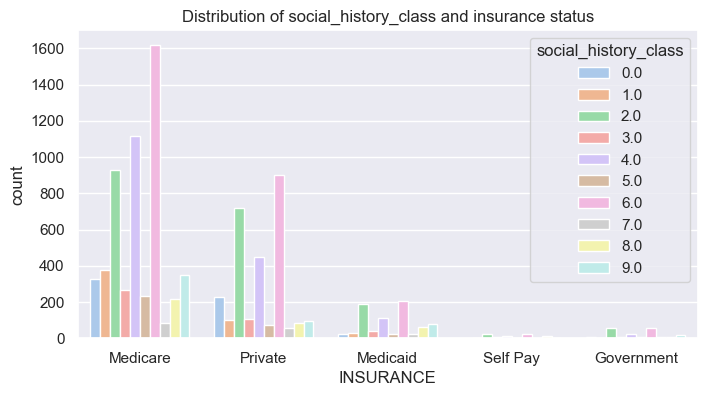

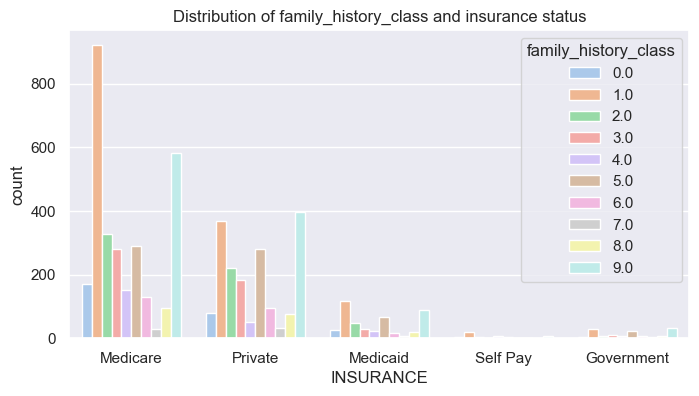

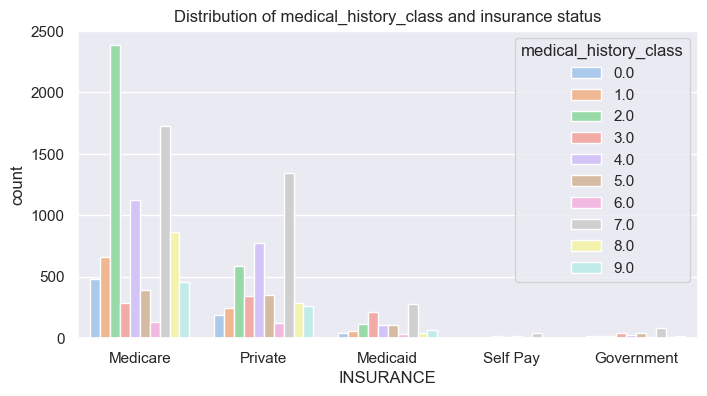

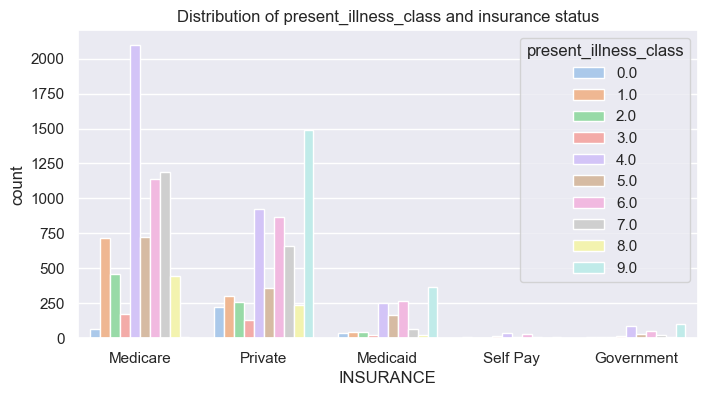

In [116]:
sns.set(rc={"figure.figsize":(8, 4)})

for classes in ['social_history_class', 'family_history_class', 'medical_history_class', 'present_illness_class']:
    plt.figure(classes)
    plt.title(f'Distribution of {classes} and insurance status')
    sns.countplot(data=notes_admissions, x='INSURANCE', hue=classes, palette=sns.color_palette('pastel'))

## insurance indicator
### social history topics
2. history of smoking (one/two packs per day)
4. smoking, alcohol, and tobacco use - attempt at quitting
6. tobacco and alcohol use; denial of drug use; marriage

### family history topics
1. history of diabetes or cardiac issues in family
5. contributory history from both parents: breast cancer, diabetes, colon, lung
9. diabetes and significant heart issues mentioned from both parents

### medical history topics
2. disease
4. surgery, cancer, hernia 
7. hypertension and diabetes mentioned

### present illness topics
medicare
4. patient admitted to emergency room wih chest pain, shortness of breath (heart attack)
6. patient was admitted to hopsital
7. patient has cardiac disease/coronary related health issues
private
9. infant related/pregnant mother brought to icu

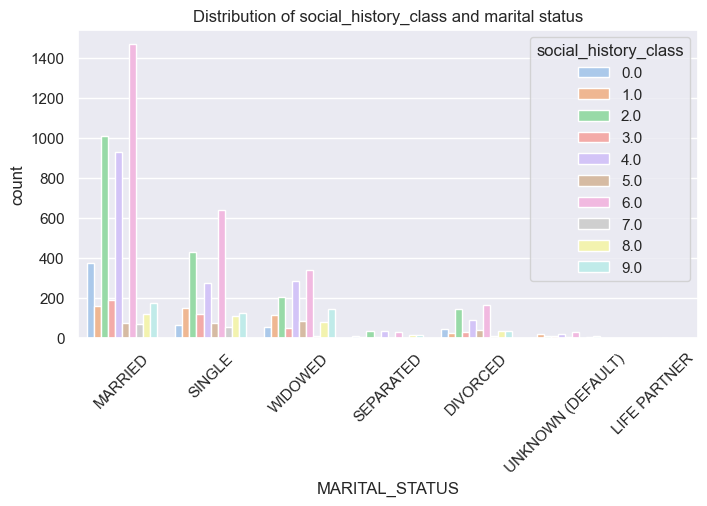

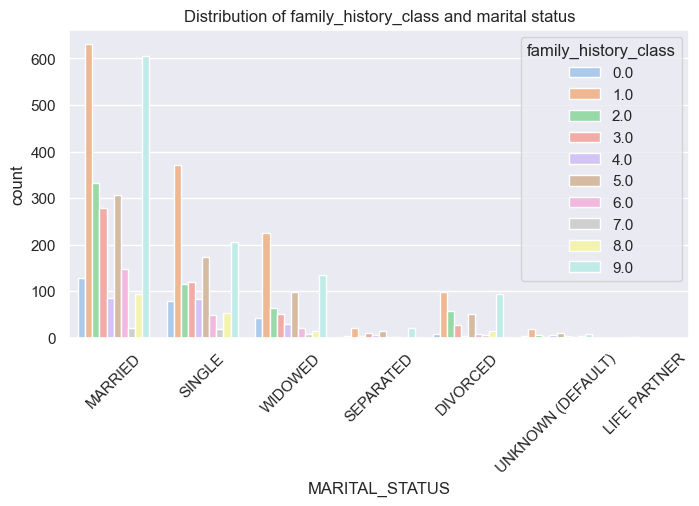

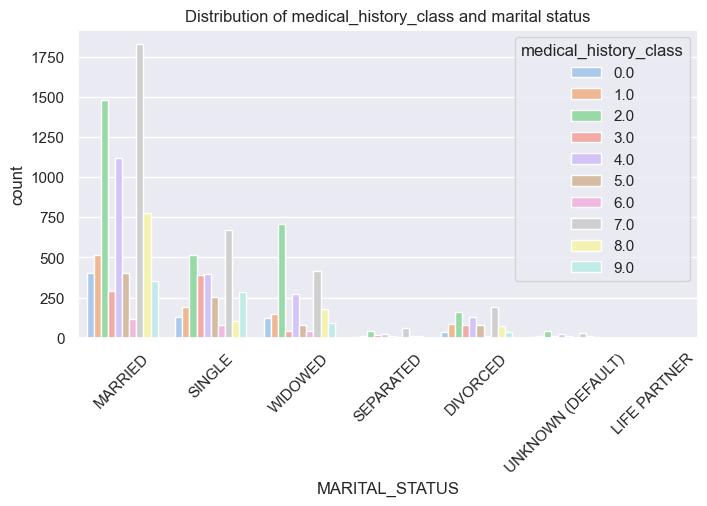

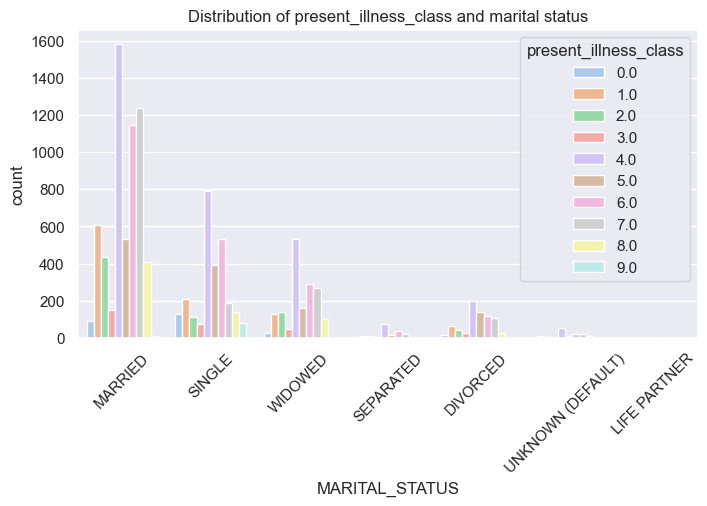

In [117]:
sns.set(rc={"figure.figsize":(8, 4)})

for classes in ['social_history_class', 'family_history_class', 'medical_history_class', 'present_illness_class']:
    plt.figure(classes)
    plt.title(f'Distribution of {classes} and marital status')

    sns.countplot(data=notes_admissions, x='MARITAL_STATUS', hue=classes, palette=sns.color_palette('pastel'))
    plt.xticks(rotation=45)
    plt.show()


## marital indicator
### social history topics
2. history of smoking (one/two packs per day)
4. smoking, alcohol, and tobacco use - attempt at quitting
6. tobacco and alcohol use; denial of drug use; marriage

### family history topics
1. history of diabetes or cardiac issues in family
5. contributory history from both parents: breast cancer, diabetes, colon, lung
9. diabetes and significant heart issues mentioned from both parents

### medical history topics
2. disease
4. surgery, cancer, hernia 
7. hypertension and diabetes mentioned
8. heart disease, coronary

### present illness topics
4. patient admitted to emergency room wih chest pain, shortness of breath (heart attack)
6. patient was admitted to hopsital
7. patient has cardiac disease/coronary related health issues
9. infant related/pregnant mother brought to icu 

In [135]:
notes_admissions['RELIGION'].value_counts()

RELIGION
CATHOLIC                  6575
UNOBTAINABLE              2629
PROTESTANT QUAKER         2352
NOT SPECIFIED             2089
JEWISH                    1933
OTHER                     1063
EPISCOPALIAN              256 
GREEK ORTHODOX            162 
CHRISTIAN SCIENTIST       103 
MUSLIM                    69  
BUDDHIST                  68  
JEHOVAH'S WITNESS         46  
7TH DAY ADVENTIST         28  
BAPTIST                   27  
UNITARIAN-UNIVERSALIST    27  
ROMANIAN EAST. ORTH       26  
HINDU                     15  
HEBREW                    15  
METHODIST                 7   
LUTHERAN                  1   
Name: count, dtype: int64

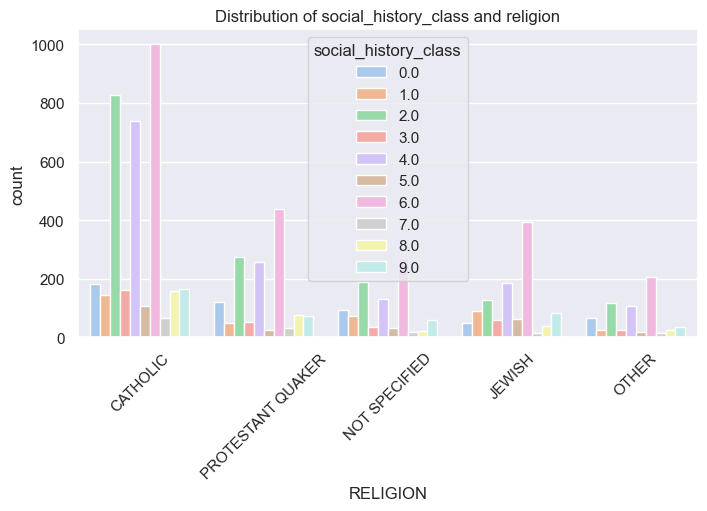

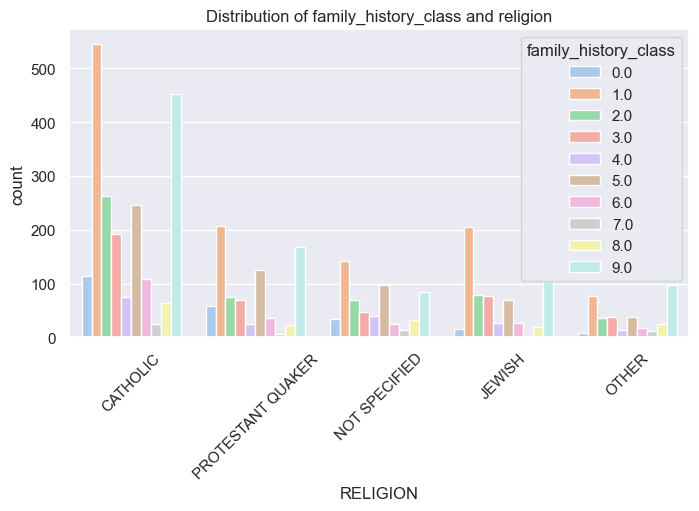

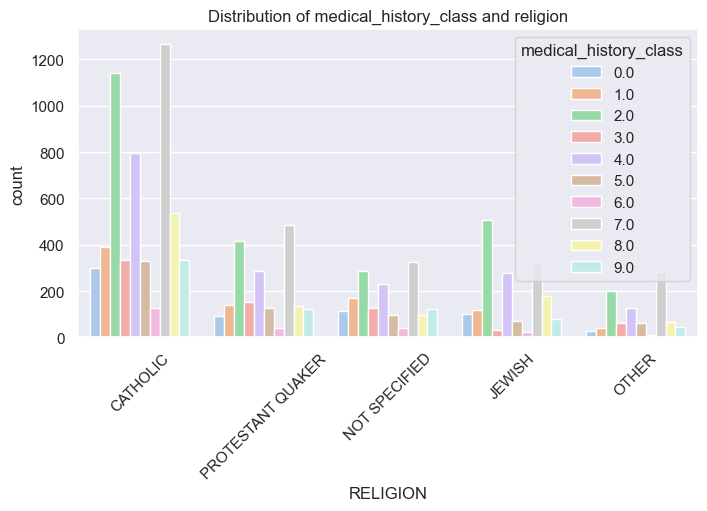

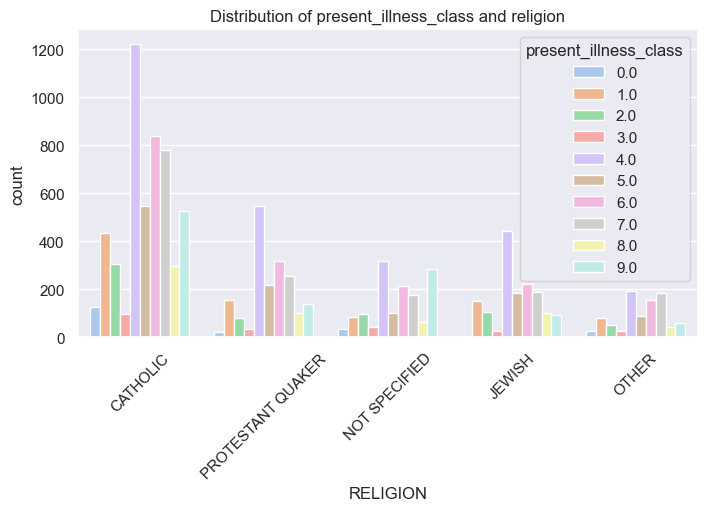

In [192]:
sns.set(rc={"figure.figsize":(8, 4)})

for classes in ['social_history_class', 'family_history_class', 'medical_history_class', 'present_illness_class']:
    plt.figure(classes)
    plt.title(f'Distribution of {classes} and religion')

    sns.countplot(data=notes_admissions[notes_admissions['RELIGION'].isin(['CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED', 'JEWISH', 'OTHER'])], 
                  x='RELIGION', hue=classes, palette=sns.color_palette('pastel'))
    plt.xticks(rotation=45)
    plt.show()

## religion indicator
### social history topics
2. history of smoking (one/two packs per day)
4. smoking, alcohol, and tobacco use - attempt at quitting
6. tobacco and alcohol use; denial of drug use; marriage

### family history topics
1. history of diabetes or cardiac issues in family
2. myocardial infarcation, family history
5. contributory history from both parents: breast cancer, diabetes, colon, lung
9. diabetes and significant heart issues mentioned from both parents

### medical history topics
2. disease
4. surgery, cancer, hernia 
7. hypertension and diabetes mentioned
8. artery, heart disease

### present illness topics
catholic
4. patient admitted to emergency room wih chest pain, shortness of breath (heart attack)
6. patient was admitted to hopsital
7. patient has cardiac disease/coronary related health issues
9. infant related/pregnant mother brought to icu
protestant quaker
4.

In [232]:
notes_admissions['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                         11904
UNKNOWN/NOT SPECIFIED                         2515 
BLACK/AFRICAN AMERICAN                        1718 
OTHER                                         452  
HISPANIC OR LATINO                            437  
ASIAN                                         348  
PATIENT DECLINED TO ANSWER                    170  
UNABLE TO OBTAIN                              66   
WHITE - RUSSIAN                               38   
HISPANIC/LATINO - PUERTO RICAN                35   
ASIAN - CHINESE                               30   
MULTI RACE ETHNICITY                          23   
BLACK/CAPE VERDEAN                            21   
PORTUGUESE                                    14   
AMERICAN INDIAN/ALASKA NATIVE                 14   
BLACK/HAITIAN                                 12   
HISPANIC/LATINO - GUATEMALAN                  11   
WHITE - OTHER EUROPEAN                        11   
MIDDLE EASTERN                                10   
HI

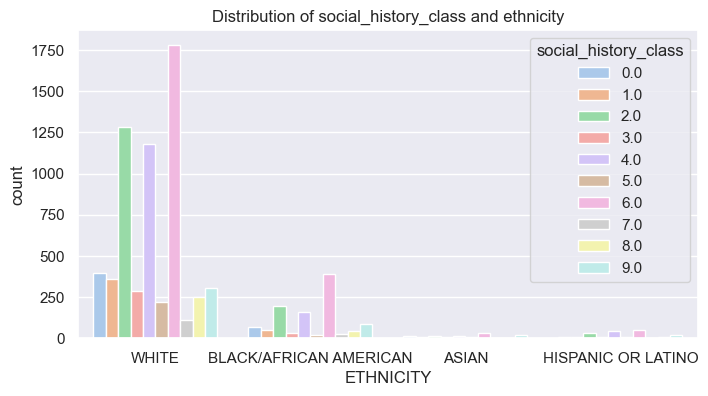

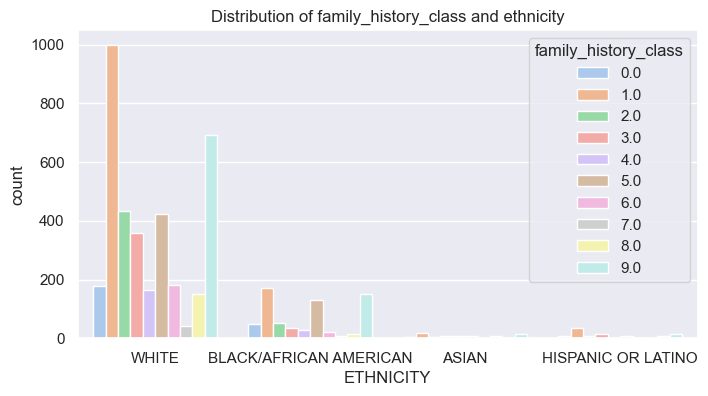

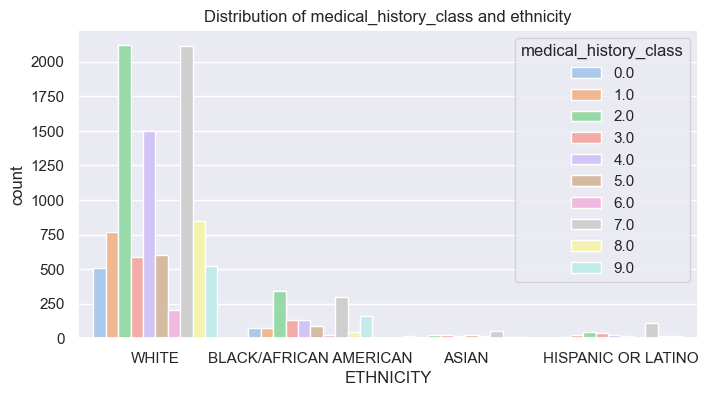

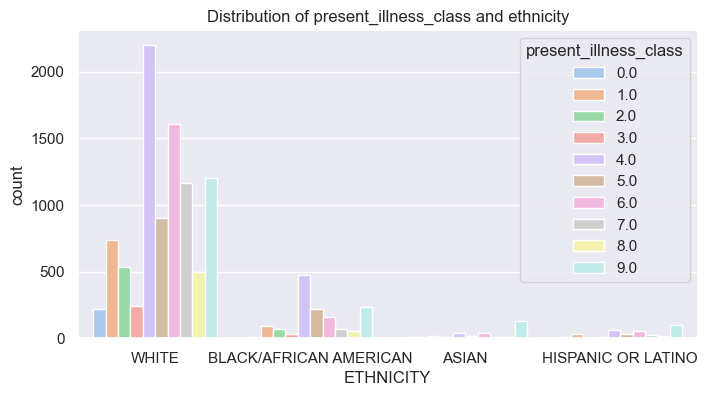

In [234]:
sns.set(rc={"figure.figsize":(8, 4)})

for classes in ['social_history_class', 'family_history_class', 'medical_history_class', 'present_illness_class']:
    plt.figure(classes)
    plt.title(f'Distribution of {classes} and ethnicity')

    sns.countplot(data=notes_admissions[notes_admissions['ETHNICITY'].isin(['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'ASIAN'])], 
                  x='ETHNICITY', hue=classes, palette=sns.color_palette('pastel'))
    # plt.xticks(rotation=45)
    plt.show()

## clustering - test

In [154]:
!pip install plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 44.4 MB/s eta 0:00:0000:0100:01


In [164]:
from IPython.display import IFrame

In [184]:
len(clusters_df)

1084

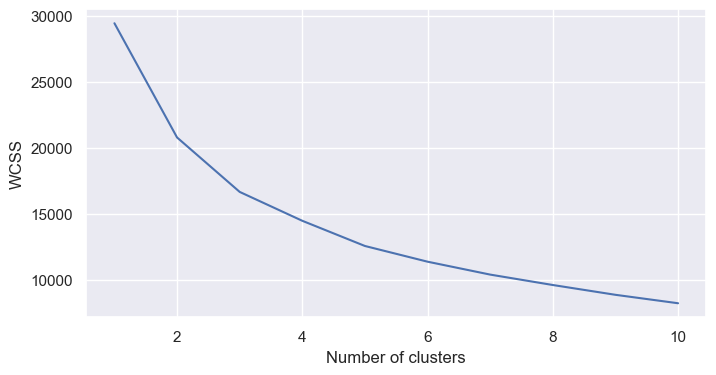

1084


/var/folders/51/42w_kz156q920kx3w9jz1lwm0000gn/T/ipykernel_24456/2225206836.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [193]:
from sklearn.cluster import KMeans
import plotly.express as px

clusters_df = notes_admissions.dropna()

tuples = list(zip(clusters_df['social_history_class'], clusters_df['present_illness_class'], 
                  clusters_df['medical_history_class'], clusters_df['family_history_class']))

# Convert tuples to numpy array
X = np.array(tuples)

wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

# # Perform K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
print(len(y_kmeans))

clusters_df['label'] = pd.Series(y_kmeans, index=clusters_df.index)


fig = px.scatter_3d(clusters_df, x='social_history_class', y='family_history_class', z='medical_history_class', color=y_kmeans, labels='label')
# fig.update_layout(scene=dict(xaxis_title='Social History', yaxis_title='Present Illness', zaxis_title='Medical History'))
fig.show()

In [229]:
pd.DataFrame(clusters_df[clusters_df['label']==0].iloc[:, 5:15].value_counts())

count
INSURANCE LANGUAGE RELIGION          MARITAL_STATUS ETHNICITY              social_history_class family_history_class medical_history_class present_illness_class label       
Medicare  ENGL     CATHOLIC          SINGLE         BLACK/AFRICAN AMERICAN 6.0                  1.0                  9.0                   5.0                   0      25   
                   JEWISH            DIVORCED       WHITE                  5.0                  2.0                  1.0                   1.0                   0      15   
Private   ENGL     CATHOLIC          MARRIED        WHITE                  9.0                  5.0                  5.0                   4.0                   0      12   
Medicare  ENGL     CATHOLIC          SINGLE         WHITE                  6.0                  3.0                  4.0                   0.0                   0      9    
                   PROTESTANT QUAKER SINGLE         BLACK/AFRICAN AMERICAN 7.0                  4.0                  3.0                   9.0                   0      9    
...                                                                                                                                                                    ..    
                   CATHOLIC          MARRIED        OTHER                  9.0                  1.0                  7.0                   6.0                   0      1    
                   PROTESTANT QUAKER MARRIED        WHITE                  6.0                  3.0                  9.0                   6.0                   0      1    
                                                                                                0.0                  7.0                   4.0                   0      1    
                   CATHOLIC          MARRIED        WHITE                  4.0                  4.0                  0.0                   4.0                   0      1    
Self Pay  SPAN     UNOBTAINABLE      DIVORCED       HISPANIC OR LATINO     6.0                  0.0                  7.0                   3.0                   0      1    

[179 rows x 1 columns]

In [223]:
pd.DataFrame(clusters_df[clusters_df['label']==1].iloc[:, 5:15].value_counts())

count
INSURANCE LANGUAGE RELIGION          MARITAL_STATUS    ETHNICITY              social_history_class family_history_class medical_history_class present_illness_class label       
Medicaid  ENGL     PROTESTANT QUAKER DIVORCED          BLACK/AFRICAN AMERICAN 6.0                  5.0                  7.0                   5.0                   1      19   
Private   ENGL     NOT SPECIFIED     SINGLE            BLACK/AFRICAN AMERICAN 6.0                  5.0                  9.0                   4.0                   1      17   
Medicare  ENGL     EPISCOPALIAN      DIVORCED          WHITE                  2.0                  9.0                  5.0                   4.0                   1      13   
                   OTHER             SINGLE            WHITE                  6.0                  9.0                  8.0                   5.0                   1      9    
Private   ENGL     CATHOLIC          MARRIED           WHITE                  7.0                  8.0                  7.0                   2.0                   1      7    
...                                                                                                                                                                       ..    
Medicare  ENGL     MUSLIM            MARRIED           BLACK/AFRICAN AMERICAN 6.0                  9.0                  4.0                   4.0                   1      1    
                   NOT SPECIFIED     DIVORCED          WHITE                  6.0                  9.0                  2.0                   4.0                   1      1    
                                     MARRIED           WHITE                  4.0                  5.0                  4.0                   8.0                   1      1    
                                                                                                   9.0                  7.0                   7.0                   1      1    
Self Pay  PORT     UNOBTAINABLE      UNKNOWN (DEFAULT) WHITE                  8.0                  9.0                  1.0                   6.0                   1      1    

[199 rows x 1 columns]

In [224]:
pd.DataFrame(clusters_df[clusters_df['label']==2].iloc[:, 5:15].value_counts())

count
INSURANCE LANGUAGE RELIGION          MARITAL_STATUS ETHNICITY              social_history_class family_history_class medical_history_class present_illness_class label       
Medicare  ENGL     NOT SPECIFIED     MARRIED        BLACK/AFRICAN AMERICAN 0.0                  2.0                  0.0                   2.0                   2      17   
Private   ENGL     PROTESTANT QUAKER DIVORCED       WHITE                  0.0                  2.0                  4.0                   7.0                   2      14   
Medicare  ENGL     CATHOLIC          SINGLE         WHITE                  3.0                  0.0                  2.0                   4.0                   2      6    
                   PROTESTANT QUAKER WIDOWED        BLACK/AFRICAN AMERICAN 2.0                  5.0                  4.0                   4.0                   2      6    
                   JEWISH            SINGLE         WHITE                  1.0                  1.0                  7.0                   6.0                   2      6    
...                                                                                                                                                                    ..    
                   CATHOLIC          SINGLE         WHITE                  2.0                  2.0                  4.0                   5.0                   2      1    
                                                                                                                     2.0                   5.0                   2      1    
                                                                                                1.0                  7.0                   4.0                   2      1    
                                                                                                0.0                  8.0                   7.0                   2      1    
Self Pay  PORT     PROTESTANT QUAKER MARRIED        OTHER                  1.0                  4.0                  5.0                   4.0                   2      1    

[185 rows x 1 columns]

## LSA

In [48]:
count_vectorizer = CountVectorizer()
dtm = count_vectorizer.fit_transform(notes_admissions['present_illness'].dropna())
print('DTM shape:', dtm.shape)

# np.log1p(dtm[i] for i in range(dtm.columns))

# Step 4: Apply Truncated SVD for dimensionality reduction (LSA)
num_topics = 5  # Choose the number of topics/components
lsa_model = TruncatedSVD(n_components=num_topics)
lsa_topic_matrix = lsa_model.fit_transform(dtm)
print('lsa_topic_matrix shape:', lsa_topic_matrix.shape)

# Display the results
terms = count_vectorizer.get_feature_names_out()
topic_terms = lsa_model.components_

# Create a DataFrame to display the results
result_df = pd.DataFrame(topic_terms, columns=terms)
result_df.insert(0, 'Topic', range(1, num_topics + 1))
print('result_df shape:', result_df.shape)

# Display the transformed documents
document_topics = pd.DataFrame(lsa_topic_matrix, columns=[f'Topic {i+1}' for i in range(num_topics)])
document_topics.insert(0, 'Text', notes_admissions['present_illness'].dropna())

print("Term-Topic Matrix:")
print(result_df)
print("\nTransformed Documents:")
print(document_topics)

DTM shape: (14223, 14141)
lsa_topic_matrix shape: (14223, 5)
result_df shape: (5, 14142)
Term-Topic Matrix:
   Topic        00       005        01       010           015        02  \
0  1      0.002566  0.000014  0.000112  0.000011  9.974223e-07  0.000287   
1  2      0.001213  0.000075  0.000193  0.000070  2.793432e-06  0.000244   
2  3     -0.001784  0.000043 -0.000006  0.000051  9.703511e-09  0.000334   
3  4      0.000842  0.000063 -0.000207  0.000040 -1.970327e-06  0.000226   
4  5      0.002829 -0.000161 -0.000360 -0.000137 -2.474444e-05 -0.000661   

        025            03       030  ...      zone  zonegran    zoning  \
0  0.000008  6.711402e-05  0.000021  ...  0.000536  0.000052  0.000013   
1  0.000032  1.918215e-07  0.000080  ...  0.002619  0.000066 -0.000009   
2  0.000028  5.384975e-05  0.000072  ... -0.002296 -0.000526  0.000008   
3  0.000068  6.169689e-05  0.000089  ...  0.001207  0.000186  0.000037   
4 -0.000138  1.498710e-05 -0.000345  ... -0.001413  0.000475  0.0

In [53]:
def max_value_and_column(df):
    max_values = df.max(axis=1)
    max_columns = df.idxmax(axis=1)
    result_df = pd.DataFrame({'Max Value': max_values, 'Column Name': max_columns})
    return result_df

max_val_col_df = max_value_and_column(document_topics.dropna().drop_duplicates().drop(columns=['Text']))
max_val_col_df['Column Name'].value_counts()

Column Name
Topic 1    11651
Topic 2    56   
Topic 5    3    
Name: count, dtype: int64

# tokenizer + clinical bert preprocessing

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT")

/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/homebrew/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
